In [1]:
BENCHMARK_TOOL = 'NVPROF' # or 'NCU'

import subprocess
import numpy as np
import pandas as pd
import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import LinearLocator, FormatStrFormatter, FuncFormatter
from matplotlib import cm 

In [2]:
KERNELS = [
    "rgb2hsv", 
    "rgb2hsv_MinimuDivergence",
    "rgb2hsv_CoordinatedOutputs",
    "histogram",
    "histogram_WithSharedMemory",
    "histogram_WithSharedMemoryAndHardcodedSize",
    "histogram_WithMinilmumCalculationDepencies",
    "repart",
    "repart_WithSharedMemory",
    "repart_WithSharedMemoryAndHardcodedSize",
    "equalization",
    "equalization_ConstantCoefficient",
    "hsv2rgb",
    "hsv2rgb_MinimuDivergence"
]

In [3]:
def read_nvprof(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[3].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

    
def read_ncu(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[2].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

def benchmark_kernel(exe_path: str, *args) -> str :
    if BENCHMARK_TOOL == 'NVPROF':
        return str(subprocess.check_output(
            ['nvprof', '--print-gpu-trace', '--csv', exe_path, *args], 
            stderr=subprocess.STDOUT
        ))
    elif BENCHMARK_TOOL == 'NCU':
        return str(subprocess.check_output(
            ['ncu','--csv', exe_path, *args], 
            stderr=subprocess.STDOUT, shell=True
        ))

def read_benchmark(output: str) -> pd.DataFrame:
    if BENCHMARK_TOOL == 'NVPROF':
        return read_nvprof(output)
    elif BENCHMARK_TOOL == 'NCU':
        return read_ncu(output)

def get_kernel_duration(df: pd.DataFrame, kernelNum=0) -> float:
    if BENCHMARK_TOOL == 'NVPROF':
        # conversion en ms 
        if df.loc[0, 'Duration'] == "ms":
            return float(df.loc[kernelNum + 1, 'Duration']) 
        if df.loc[0, 'Duration'] == "s":
            return float(df.loc[kernelNum + 1, 'Duration']) * 1e3
        # probablement en micro seconde
        return float(df.loc[kernelNum + 1, 'Duration']) * 1e-3
    elif BENCHMARK_TOOL == 'NCU':
        return float(df[df['Metric Name'] == 'Duration']['Metric Value'].to_numpy().item().replace(',','')) * 1e-6

In [4]:
# Renvoie les durée moyennes en fonction de variation de tailles de l'axe X des blocs pour un certain kernel
def evaluateBlocSize(kernelType, nTry = 10):  
    durations = []
    sizes = []
    avg = 0
    xBlockSize, yBlockSize = 1, 1
    
    while xBlockSize <= 1024:
        for _ in range(nTry) :         
            avg += get_kernel_duration(read_benchmark(
                benchmark_kernel("./hist", 
                    "-f", "./img/chateau.png", 
                    "-b", str(kernelType), 
                    "-d", str(xBlockSize), str(yBlockSize)
                )
            ), kernelType)

        avg /= nTry
        durations.append(avg)    
        sizes.append(xBlockSize)
        xBlockSize *= 2
    return durations, sizes

In [5]:
def showHistogramDuration(durations, sizes, title, xLabel, yLabel):
    plt.title(title)  
    plt.xlabel(xLabel) 
    plt.ylabel(yLabel) 
    plt.bar(np.array(sizes).astype(str), np.array(durations), width=.8) 
    plt.show()

def showHistogramOfKernels(kernels, nTry = 10):  
    i = 0
    for k in kernels: 
        durations, sizes = evaluateBlocSize(i, nTry)
        showHistogramDuration(durations, sizes, k, "taille de bloc", "ms") 
        i+=1
 
print("Évaluation des kernels suivant la variation de la taille des blocs sur l'axe X") 
#showHistogramOfKernels(KERNELS, 5)

Évaluation des kernels suivant la variation de la taille des blocs sur l'axe X


In [6]:
def evaluate2DBlocSize(kernelType, nTry = 10):  
    durations = []
    sizes = [] 
    xBlockSize = 1
    step = 64

    while xBlockSize <= 1024:
        yBlockSize = 1
        durations.append([])
        while yBlockSize <= 1024:
            if (xBlockSize * yBlockSize) > 1024:
                durations[-1].append(np.nan)    
                #yBlockSize += step
                yBlockSize *= 2
                continue
            
            avg = 0 
            for _ in range(nTry) :         
                avg += get_kernel_duration(read_benchmark(
                    benchmark_kernel("./hist", 
                        "-f", "./img/chateau.png", 
                        "-b", str(kernelType), 
                        "-d", str(xBlockSize), str(yBlockSize)
                    )
                ), kernelType)

            avg /= nTry
            durations[-1].append(avg)   
            #yBlockSize += step if yBlockSize != 1 else -1
            yBlockSize *= 2
        sizes.append(xBlockSize)
         
        #xBlockSize += step if xBlockSize != 1 else -1
        xBlockSize *= 2
    return durations, sizes
 

In [7]:
print("Variation de la taille des blocs rgb to hsv")
durations, sizes = evaluate2DBlocSize(0, 1)   
print(durations)
print(sizes)

Variation de la taille des blocs rgb to hsv
[[0.158848, 0.176575, 0.181823, 0.157983, 0.159455, 0.167071, 0.155648, 0.153631, 0.179647, 0.159391, 0.156128], [0.156671, 0.157568, 0.158368, 0.155648, 0.158399, 0.156223, 0.158016, 0.161536, 0.158655, 0.155679, nan], [0.156447, 0.158527, 0.159424, 0.155264, 0.156735, 0.156255, 0.158496, 0.157151, 0.156383, nan, nan], [0.157183, 0.158975, 0.157023, 0.159263, 0.180351, 0.158911, 0.15712, 0.162559, nan, nan, nan], [0.159423, 0.15648, 0.226207, 0.165375, 0.158272, 0.156959, 0.267711, nan, nan, nan, nan], [0.183423, 0.156383, 0.15504, 0.156607, 0.157312, 0.216384, nan, nan, nan, nan, nan], [0.158239, 0.159039, 0.15824, 0.159488, 0.192094, nan, nan, nan, nan, nan, nan], [0.176927, 0.157951, 0.156575, 0.157247, nan, nan, nan, nan, nan, nan, nan], [0.156127, 0.155999, 0.159263, nan, nan, nan, nan, nan, nan, nan, nan], [0.15952, 0.159295, nan, nan, nan, nan, nan, nan, nan, nan, nan], [0.156416, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]
[1,

In [18]:
def getBestParameters(durations, sizesX, sizesY):
    m = durations[0][0]
    x = 1
    y = 1

    for i in range(len(durations)):
        for j in range(len(durations[i])):  
            if (durations[i][j] < m and durations[i][j] != np.nan):
                m = durations[i][j]
                x = sizesX[i] 
                y = sizesY[j] 

    return m, x, y 

def log_tick_formatter(val, pos=None): 
    return int(10**val)
    #return "{:.2e}".format(10**val)
    #return r"$10^{{{:.0f}}}$".format(val)

def showHistogramDuration3DHist(durations, sizesX, sizesY, title, xLabel, yLabel): 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Temps d'éxecution du kernel: " + title)
 
    xpos, ypos = np.meshgrid(sizesX, sizesY)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F') 
    dz = np.array(durations).flatten()  
    minZ, maxZ = min(dz), max(dz)
    zpos = np.full_like(dz, minZ, dtype=np.double)  
    cmap = cm.get_cmap('jet')   
    rgb = [cmap((k-minZ)/ (maxZ)) for k in dz] 
    dz = np.array([d - minZ for d in dz])
    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()   
    hist = ax.bar3d(np.log10(xpos), np.log10(ypos), zpos, 0.13, 0.13, dz, color=rgb, alpha=0.3, zsort='average')

    # Customize the z axis.  
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.03f'))

    ax.xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter)) 
  
    #ax.set_zlim(minZ /2, maxZ * 2)
    ax.set_zlim(minZ, maxZ)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel) 
    ax.set_zlabel("durée (en ms)")  
    # Add a color bar which maps values to colors.evaluate2DBlocSize(4, 1)  
    d, x, y  = getBestParameters(durations, sizesX, sizesY) 
    plt.figtext(0.53, -0.03, "Meilleur temps: " + str(minZ) + " ms\navec " + xLabel + " : " + str(x) + "\n    et" + yLabel + " : " + str(y) , ha="center", bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    plt.show()

  

In [19]:
 

def testBlocKernels(kernels, nTry = 1):
    for i in range(len(kernels)):
        print("Execution du kernel : ", kernels[i], "avec ", nTry, " essaie.")

        durations, sizes = evaluate2DBlocSize(0, nTry)   
        showHistogramDuration3DHist(durations, sizes, sizes, kernels[i], "taille de bloc x", "taille de bloc y") 
 
 

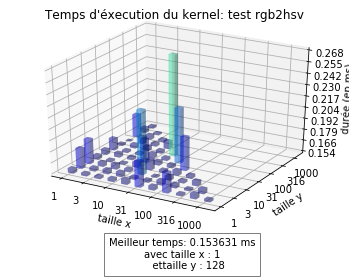

In [20]:
getBestParameters(durations, sizes, sizes)    
showHistogramDuration3DHist(durations, sizes, sizes, "test rgb2hsv", "taille x", "taille y")

In [21]:
testBlocKernels(KERNELS, 10)

Execution du kernel :  rgb2hsv avec  10  essaie.


CalledProcessError: Command '['nvprof', '--print-gpu-trace', '--csv', './hist', '-f', './img/chateau.png', '-b', '0', '-d', '32', '8']' returned non-zero exit status 9.